##Face expression recognition with Deep Learning

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import numpy as np
import pandas as pd

In [35]:
train_path = '/content/drive/MyDrive/datasets/face-expression-recognition-dataset/images/train'
valid_path = '/content/drive/MyDrive/datasets/face-expression-recognition-dataset/images/validation'

In [36]:
TRAIN = tf.keras.utils.image_dataset_from_directory(train_path)
VALID = tf.keras.utils.image_dataset_from_directory(valid_path)
print(TRAIN)

Found 817 files belonging to 7 classes.
Found 1036 files belonging to 7 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


#unbatch the Dataset to drop all classes except 'happy' and 'sad'

In [37]:
TRAIN_unbatched = TRAIN.unbatch()
VALID_unbatched = VALID.unbatch()

In [38]:
def drop_extra_classes(x,y):
    if y == 3: return True
    if y == 5: return True
    return False

train = TRAIN_unbatched.filter(drop_extra_classes)
valid = VALID_unbatched.filter(drop_extra_classes)
print(train)
print(valid)

<_FilterDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


train input shape:  (256, 256, 3) input type:  <class 'numpy.ndarray'>
train label shape:  () label type:  <class 'numpy.int32'>
validation input shape:  (256, 256, 3) input type:  <class 'numpy.ndarray'>
validation label shape:  () label type:  <class 'numpy.int32'>


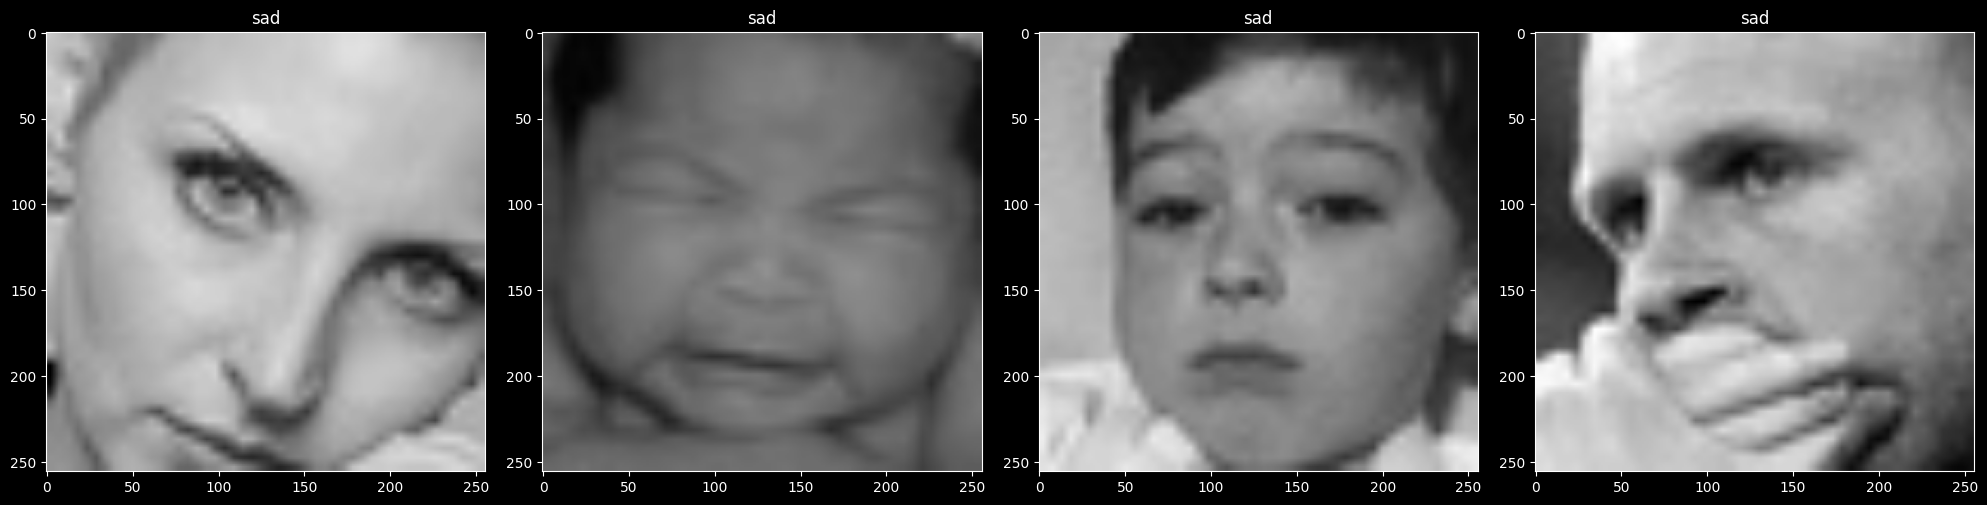

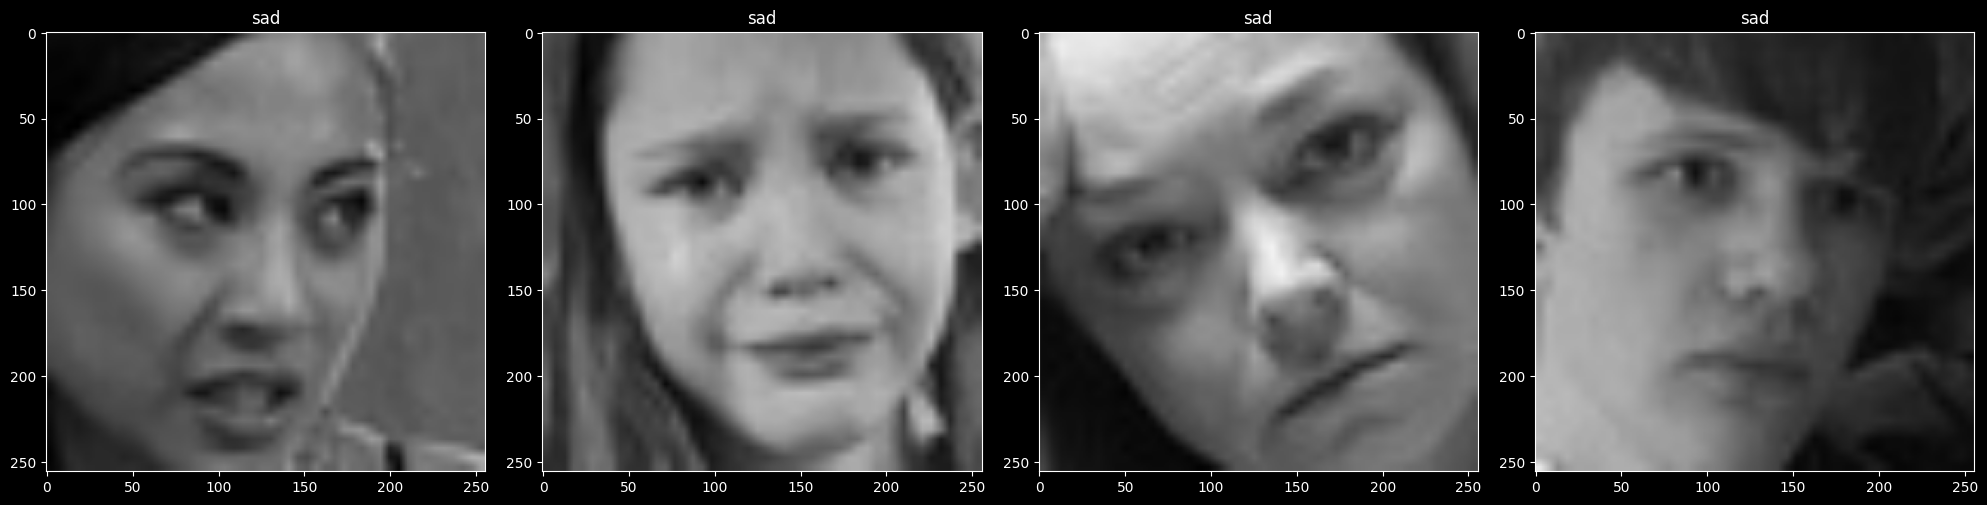

In [40]:
labels = {3:'happy', 5:'sad'}
plt.style.use('dark_background')
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for col in range(4):
    x,y = train.shuffle(buffer_size=1000).as_numpy_iterator().next()
    ax[col].imshow(x.astype(int))
    ax[col].set_title(labels[y])
print('train input shape: ',x.shape, 'input type: ',type(x))
print('train label shape: ',y.shape, 'label type: ',type(y))
plt.tight_layout()

labels = {3:'happy', 5:'sad'}
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for col in range(4):
    x,y = valid.shuffle(buffer_size=1000).as_numpy_iterator().next()
    ax[col].imshow(x.astype(int))
    ax[col].set_title(labels[y])
plt.tight_layout()
print('validation input shape: ',x.shape, 'input type: ',type(x))
print('validation label shape: ',y.shape, 'label type: ',type(y))

In [19]:
# Preprocess the data
train = train.map(lambda x,y: (x/255,y))
valid = valid.map(lambda x,y: (x/255,y))
x,y = train.as_numpy_iterator().next()

In [20]:
def rename_labl(x,y):
    label = np.int32(-1)
    if y==3: label = np.int32(1)
    if y==5: label = np.int32(0)
    return x,label

In [21]:
train = train.map(rename_labl)
valid = valid.map(rename_labl)
for i in range(10):
    x,y = train.as_numpy_iterator().next()
    print(y, end=' ')

0 1 0 1 0 1 1 1 0 1 

In [22]:
print('train input shape: ',x.shape, 'input type: ',type(x))
print('train label shape: ',y.shape, 'label type: ',type(y))

train input shape:  (256, 256, 3) input type:  <class 'numpy.ndarray'>
train label shape:  () label type:  <class 'numpy.int32'>


In [23]:
train = train.batch(batch_size = 50)
valid = valid.batch(batch_size = 50)

In [24]:
import gc
del TRAIN, TRAIN_unbatched, VALID, VALID_unbatched
gc.collect()

12670

In [25]:
# Importing Deep Learning Libraries
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D,Input
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

model = Sequential()

#1st CNN layer
model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#3rd CNN layer
model.add(Conv2D(128,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Fully connected 2st layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 254, 254, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 128)     7

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

#Model training

In [28]:
hist = model.fit(train, epochs=50, validation_data=valid, callbacks=[tensorboard_callback,reduce_learningrate, early_stopping])

Epoch 1/50
5/5 [==============================] - 32s 4s/step - loss: 0.9270 - accuracy: 0.5000 - val_loss: 0.7808 - val_accuracy: 0.3415 - lr: 0.0010
Epoch 2/50
5/5 [==============================] - 7s 1s/step - loss: 0.8054 - accuracy: 0.5435 - val_loss: 0.7225 - val_accuracy: 0.3817 - lr: 0.0010
Epoch 3/50
5/5 [==============================] - 7s 1s/step - loss: 0.7335 - accuracy: 0.5739 - val_loss: 0.7083 - val_accuracy: 0.4241 - lr: 0.0010
Epoch 4/50
5/5 [==============================] - 8s 2s/step - loss: 0.7625 - accuracy: 0.5522 - val_loss: 0.7110 - val_accuracy: 0.3996 - lr: 0.0010
Epoch 5/50
5/5 [==============================] - 9s 2s/step - loss: 0.6807 - accuracy: 0.5913 - val_loss: 0.7177 - val_accuracy: 0.3929 - lr: 0.0010
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.6408 - accuracy: 0.6435
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5/5 [==============================] - 9s 2s/step - loss: 0.6408 - accuracy: 0.6

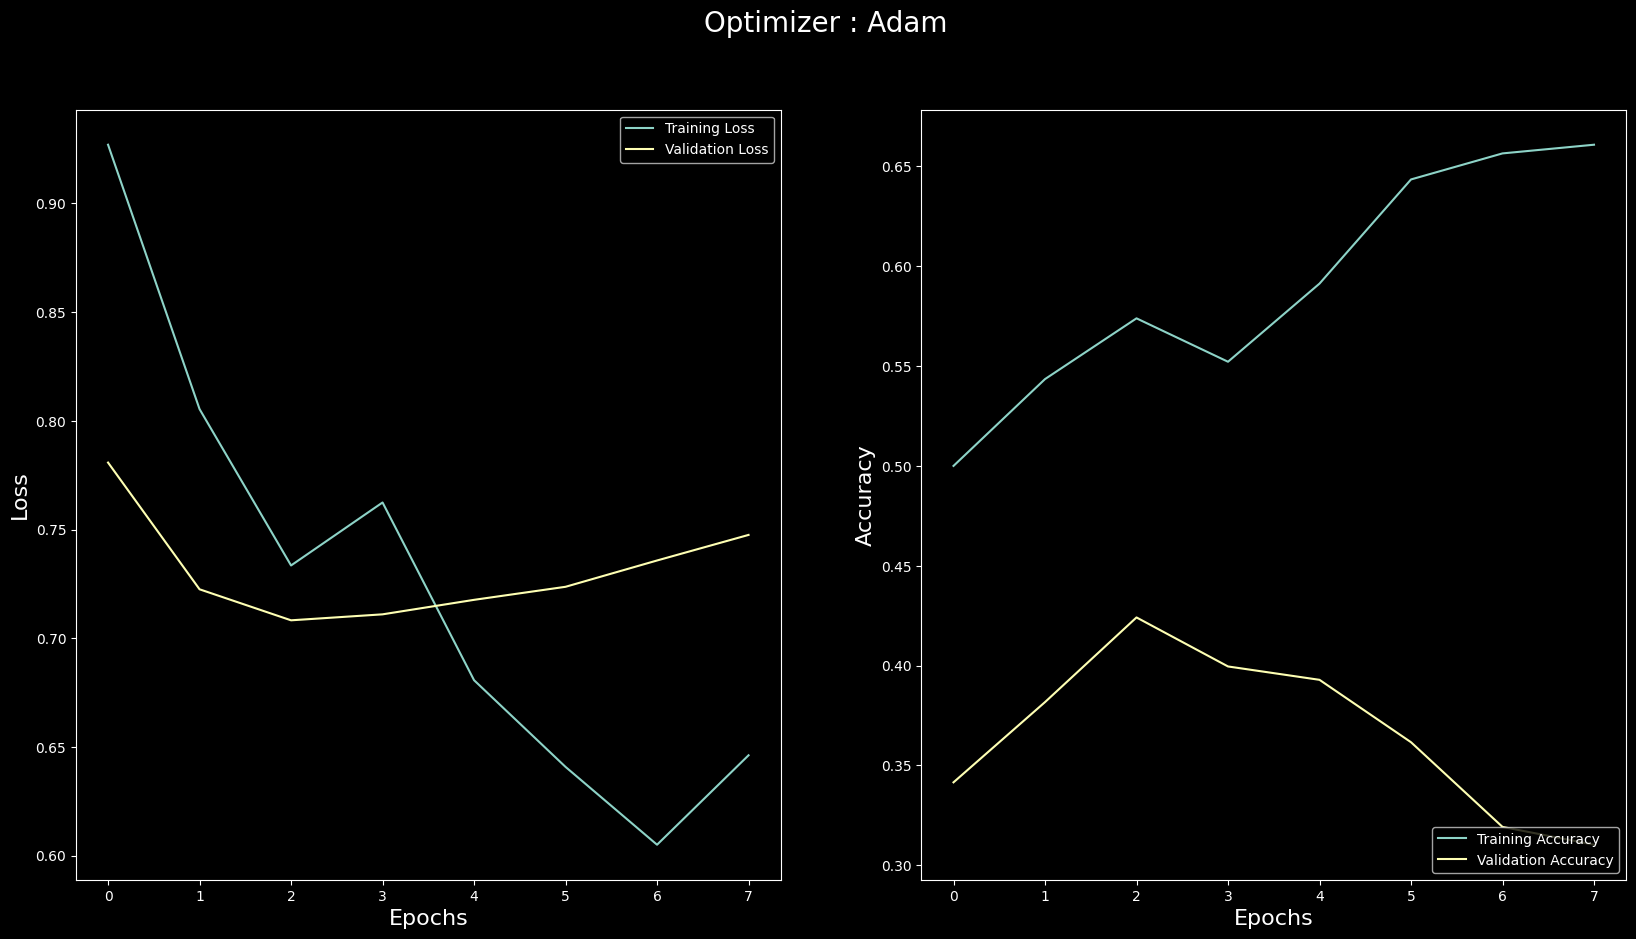

In [31]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()